In [1]:
1

1

In [2]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle
import matplotlib.pyplot as plt

In [3]:
#make the model
def create_model(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
    #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [27]:
J = 8
Q = 1
order = 2
pkl_path = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-train.pkl'
pkl_file = open(pkl_path, 'rb')
Sy_train,y_train = pickle.load(pkl_file) 

pkl_path_val = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-val.pkl'
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
#Sy_val = Sy_val.reshape((Sy_val.shape[2],Sy_val.shape[0],Sy_val.shape[1]))

pkl_path_test = "/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-test.pkl"
pkl_test = open(pkl_path_test,'rb')
Sy_test,y_test = pickle.load(pkl_test)

In [5]:
#fix everybody's physical parameters first (p and D should be log)
#print(np.log10(y_train[0,3]),y_train[0,3])
import math
for idx in range(2,4):
    y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
    y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]
    y_val[:,idx] = [math.log10(i) for i in y_val[:,idx]]

In [6]:
df_train = pd.read_csv("./train_param.csv")
df_test = pd.read_csv("./test_param.csv")
df_val = pd.read_csv("./val_param.csv")
df_full = pd.read_csv("./diffshapes_param.csv")

# normalization of the physical parameters
params = df_train.values[:,1:-1]
for idx in range(2,4):
    params[:,idx] = [math.log10(i) for i in params[:,idx]]

scaler = MinMaxScaler()
scaler.fit(params)

#normalize training and validation set
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)
y_test_normalized = scaler.transform(y_test)

In [7]:
input_x = Sy_train.shape[1]
input_y = Sy_train.shape[2]

In [8]:
Sy_train_pos=(Sy_train>0)*Sy_train+1e-10
Sy_val_pos = (Sy_val>0)*Sy_val+1e-10

In [9]:
Sy_train_log = np.log(Sy_train_pos)
Sy_val_log = np.log(Sy_val_pos)
Sy_test_log = np.log((Sy_test>0)*Sy_test+1e-10)

In [35]:
Sy_val_log = Sy_val_log.reshape((7776,128,43))

In [36]:
print(Sy_train_log.shape,Sy_val_log.shape,Sy_train.shape,y_train.shape,y_val.shape)

(82224, 128, 43) (7776, 128, 43) (82224, 128, 43) (82224, 5) (7776, 5)


In [8]:
eps = 1e-3*np.median(np.ndarray.flatten(Sy_train[0,:,:]))

In [28]:
Sy_train_log2 = np.log1p(((Sy_train>0)*Sy_train)/1e-11)
Sy_val_log2 = np.log1p(((Sy_val>0)*Sy_val)/1e-11)
Sy_test_log2 = np.log1p((Sy_test>0)*Sy_test/1e-11)

In [29]:
print(np.max(np.max(np.max(Sy_train_log2))),np.min(np.min(np.min(Sy_train_log2))))

24.584995 -0.0


In [31]:
Sy_val_log2.shape

(7776, 128, 43)

(array([ 16.,  45.,  90.,  91.,  50.,  10.,   6.,  13.,  22.,  37.,  73.,
        102., 159., 227., 212., 199., 188., 130., 137., 131., 208., 214.,
        235., 184., 192., 245., 351., 460., 530., 492., 451., 313., 243.,
        192., 159., 135., 201., 212., 222., 226., 185., 125., 130., 135.,
        192., 161., 134.,  73.,  95.,  76., 132., 167., 142.,  98.,  47.,
         47.,  87., 159., 221., 228., 126.,  97., 130., 121.,  81.,  94.,
         81.,  53.,  22.,  13.,  11.,  32.,  36.,  67., 121., 153., 120.,
         84.,  88.,  66.,  27.,   1.,   1.,  35.,  56.,  80.,  95.,  32.,
          0.,   0.,   0.,  37.,  82., 109., 161., 224.,  95.,  75.,  83.,
         31.]),
 array([11.785914 , 11.9023075, 12.018701 , 12.135095 , 12.251488 ,
        12.367881 , 12.484274 , 12.600667 , 12.717061 , 12.833454 ,
        12.949847 , 13.06624  , 13.182633 , 13.2990265, 13.415421 ,
        13.531814 , 13.648207 , 13.7646   , 13.880993 , 13.997387 ,
        14.11378  , 14.230173 , 14.346566 , 14

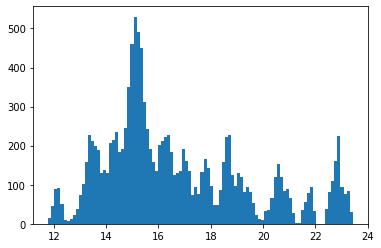

In [32]:
plt.hist(np.ndarray.flatten(Sy_val_log2[1:300,1,:]),100)

In [47]:
trial_dir = "../output/"
best_validation_loss = np.inf
n = Sy_train.shape[0]
steps_per_epoch = 10
bs = 128
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
for epoch in range(30):
    np.random.shuffle(idx)
    Sy_temp = Sy_train_log2[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val_log2,y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss.append(validation_loss)
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        epoch_str = "epoch-" + str(epoch).zfill(3)
        epoch_network_path = os.path.join(
           trial_dir, "_".join(["j8o2", epoch_str]) + "-log2.h5")
        model.save(epoch_network_path)
        

Train on 1280 samples, validate on 7776 samples
1280/1280 - 1s - loss: 1.2639 - mean_squared_error: 1.2639 - val_loss: 0.3004 - val_mean_squared_error: 0.3004


RuntimeError: Can't decrement id ref count (file write failed: time = Mon Mar 16 17:33:30 2020
, filename = '../output/j8o2_epoch-000-log2.h5', file descriptor = 71, errno = 5, error message = 'Input/output error', buf = 0x5612e187adc0, total write size = 8192, bytes this sub-write = 8192, bytes actually written = 18446744073709551615, offset = 269528)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 193, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Mon Mar 16 17:33:30 2020
, filename = '../output/j8o2_epoch-000-log2.h5', file descriptor = 71, errno = 5, error message = 'Input/output error', buf = 0x5612e187adc0, total write size = 8192, bytes this sub-write = 8192, bytes actually written = 18446744073709551615, offset = 269528)


OSError: Write through page buffer failed (file write failed: time = Mon Mar 16 17:33:31 2020
, filename = '../output/j8o2_epoch-000-log2.h5', file descriptor = 71, errno = 5, error message = 'Input/output error', buf = 0x5612e187c860, total write size = 2528, bytes this sub-write = 2528, bytes actually written = 18446744073709551615, offset = 52520)

In [46]:
i=14
original = y_test_normalized[i,:]
Sx = Sy_test_log2[i,:,:]
recovered = model.predict(Sx.reshape((1,128,43)))
print(original,recovered)

[0.7164924  0.56152385 0.55240168 0.70497154 0.19658086] [[0.6347436  0.7791218  0.60000694 0.53311974 0.66367996]]


In [43]:
print(original,recovered)

[0.07411863 0.84310174 0.55710213 0.29067493 0.91585758] [[0.50843346 0.4044962  0.436315   0.616282   0.67034876]]


In [94]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model2.load_weights("../output/j8o2_epoch-010-log.h5")

In [102]:
i=10
original = y_val_normalized[i,:]
Sx = Sy_val_log[i,:,:]
recovered = model2.predict(Sx.reshape((1,128,43)))
print(original,recovered)

[0.20074233 0.21241233 0.29568269 0.3465709  0.61794634] [[0.6769525  0.41720343 0.50097567 0.31678683 0.4856045 ]]


In [96]:
model2.evaluate(Sy_test_log,y_test_normalized)

10000/10000 [==============================] - 1s 103us/sample - loss: 0.1079 - mean_squared_error: 0.1079


[0.10794696642160416, 0.10794697]

In [97]:
model2.evaluate(Sy_train_log,y_train_normalized)

82224/82224 [==============================] - 8s 92us/sample - loss: 0.1080 - mean_squared_error: 0.1080


[0.10798504122803475, 0.10798498]

In [98]:
model2.evaluate(Sy_val_log,y_val_normalized)

7776/7776 [==============================] - 1s 92us/sample - loss: 0.0482 - mean_squared_error: 0.0482


[0.04822170173312411, 0.04822173]